$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$

<img src="../3600.jpg" width=500 />

# Tutorial 6: Generative models
and a little bit about unsupervised learning

## Todays Agenda
---
- Reminders and recaps
- Discriminative Vs. Generative
- VAE
- GAN
    - Adversery training
    - Nash Equilibrium
    - GANs Training Steps
- conditional GAN
- GANs today
- when to use what model 

## imports
---

In [112]:
# Setup
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset 


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
# sklearn imports
from sklearn import mixture
from sklearn.manifold import TSNE

## Reminders and recaps
---

we learned what is an autoencoder (AE) and the latent representation and we've talked about the Transformer architecture.

<img src="resources/edSEG.png" width="700"/>,
<img src="resources/transformer.png" width="500"/>


The AE we're seeing here is a dense prediction (semantic segmentation task).

we also used, without a lot of explanation, the GPT2 model.
somehow, we generated new text, just from tokens we've provided to the model...

but how do we generate images? and more important, do we need to give the model somewhere to start? (like text, or doodling).

we will try to answer all of those qustions in todays tutorial.

## Discriminative Vs. Generative
---

**Discriminative** models, is a term for most of the models we saw in the course so far: we're trying to learn  $P(Y\mid X)$.
for that type of models, we have to use labels, so we use supervised learning setup.<br>
they do not model $P(X)$, and when we want to generate a new image, or actually any kind of data, we need to sample $P(X)$.



**Generative** models- estimate $P(X)$, ratter implicitly (GANs) or explicitly (Variational Autoencoders - VAEs).<br>
once we did that, we can simply sample $P(X)$.


<center><img src="resources/gen_disc_model-1.jpg" width="900"/></center>

##  Classical approach
---

If you think of it, and all we need to do is to estimate $\mathcal{P}(\vec{X})$ and then sample it, we're actually trying to do an unsupervised learning task.<br>

this is a hard task, since the distribution could be from a very high dimention, as we mentioned before, for an image of 1000x1000 we need to estimate $\mathcal{P}(\vec{X}) \in \mathcal{R}^{1000000}$

that being said, if you deal with low dimentional data, we have some tricks in our sleeve to deal with it...

simplest is [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation), but i want to show you another cool idea..

### Gausian mixture model
while the truth is, you can use mixture model with other distibutions, the core idea is just an extand of K-Means that you know from ML course.
reminder:

**input: K (means), STOP condition (epsilon change/ steps), metric function**
1. set K means
**while condition**<br>

2. assign each $x_i$ to the mean with the minimum distance<br>
3. calculate new means<br>

<center><img src="resources/kmeans.png" width="600"/></center>

**GMM** simply take into consideration, not only the mean, but a distribution as a gausian.<br>
the algorithm is called Expectation Maximization, since we want to cluster each point to the class that in expectation is most likely.<br>
for each $x_i$ we estimate $\mathcal{P}(x_i | k_j)$ for all the N kernels. 

<center><img src="resources/EMGMM.png" width="600"/></center>

[explanation from youtube](https://www.youtube.com/watch?v=XLKoTqGao7U&ab_channel=VictorLavrenko)

and the results could be much better in some cases, since we actually learning distibutions:
<center><img src="resources/gmm_vs_kmeans_1.png" width="600"/></center>

The reason we see that algorithm, is not (only) because unsupervised learning is cool,<br>
but (also) because unlike KNN, now we can ignore the clustering we did, and we have K kernels of a gausian distributions...

if we normelize the sum all of them, over all the space we can sample -to 1, we can have a multi-dimention kernel function of the data.

that's how we can create $\mathcal{P}(X)$ and sample out of it.

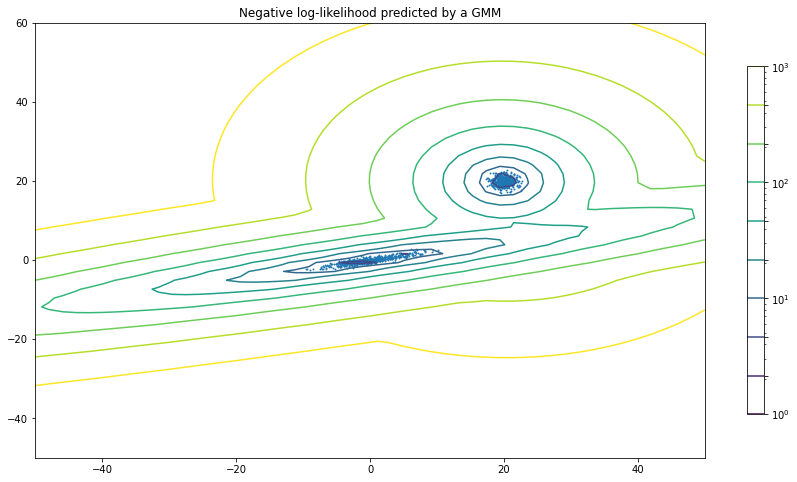

In [113]:
from matplotlib.colors import LogNorm

n_samples = 500

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[-1.0, -0.7], [3.5, 0.7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
clf.fit(X_train)


# display predicted scores by the model as a contour plot
x = np.linspace(-50.0, 50.0)
y = np.linspace(-50.0, 60.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure(figsize=(15, 8))
CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], 0.8)


plt.title("Negative log-likelihood predicted by a GMM")
plt.axis("tight")
plt.show()

In [114]:
print(np.exp(-1*Z[25,30]) > np.exp(-1*Z[1,25]))

flat = np.exp(-1*Z.flatten())
flat /= np.sum(flat)
inds=[]
for i in range(10):
    inds+= [np.random.choice(a=flat.size, p=flat)]
    inds[-1] = [inds[-1]//50,inds[-1]%50]
inds

True


[[31, 34],
 [22, 24],
 [22, 23],
 [22, 24],
 [22, 24],
 [31, 34],
 [31, 34],
 [22, 23],
 [31, 34],
 [22, 24]]

#### there are many generative models, you can read about some of them [here](https://en.wikipedia.org/wiki/Generative_model)

if you remember `N-GRAM` that we learned about 4 weeks ago, if you think of it, it's also a generative model (it's a type of `HMM` from order N-1).

In Deep learning frameworks, we're going to focus on 2 kinds of generative models: `VAEs` and `GANs`

## Variational-Autoencoder (VAE)
---

The idea is very similar to AutoEncoder that we've already saw.<br>

Now we can work in an unsupervised fashion. means, we don't need labels.

given an image $\vec{X}$, we use a decoder to project it to a latent space $\vec{H}$, and out goal is (in the simple setting) to reconstruct $\vec{X}$<br>


now since the goal here is to create an explicitly generative model, our goal is to learn the distribution of the data $P(\vec{X})$

one way to do it is to encode the data into 2 vectors, of $\mu$ and $\sigma$, compose a normal vector out of them, and use decoder to go back to the image space 

<center><img src="resources/Basic-structure-of-Variational-Autoencoder-VAE.png" width="750"/></center>

The idea behind VAEs:
* In VAE we infer the posterior $p_{\theta}(z|X)$ using a method calld **Variational Inference (VI)** (hence the name **Variational** Autoencoder).
* **Variational Inference (VI)** - solve an optimization problem in which we model $p_{\theta}(z|X)$ using a simpler distribution, $Q$ or $q_{\phi}(z|X)$, which is easier to evaluate, like a Gaussian, and **minimize the difference between these distributions using the KL-divergence**.
    * This makes sense because while we have some knowledge of $X$ (e.g., we have images of dogs), we have no clue what $z$ looks like! Not even one single $z$ that we can compare to. Had we known what $z$ looks like, we could just formulate this as two mapping problems ($x \to z$ and $z \to x$), where we have ground-truth for each direction of the mapping.
    * On the other hand, let's assume we have $z$, we can model $p_{\theta}(X|z)$. means, for a given $z$ we can simply maximize its likelihood.

## Kullback-Leibler divergence
---

**Kullback-Leibler divergence** is a metric to measure quasi-distance between 2 distributions:

$$
D_{KL}(P || Q) = \sum_{x \in \mathcal{X}} P(x) log(\frac{P(x)}{Q(x)})
$$

In other words, it is the expectation of the logarithmic difference between the probabilities P and Q.<br>

now you can see why this is a quasi-distance?<br>
$$ D_{KL}(P || Q) \ne D_{KL}(Q || P) $$


So it's a bit confusing, what does it mean for our VAE and what distribusion is the real one?

as we denoted before $p_{\theta}(z|X)$ is the distribution we can learn, and $q_{\phi}(z|X)$ is a simpler distribution we can determine. ($\theta$ is learnable while $\phi$ is deducable)


The first step is to **choose Q**. and a choice that make sence is $\mathcal{N}(0,1)$.
then, we need to understand if we want $ D_{KL}(P || Q) $ or $ D_{KL}(Q || P) $

short ansswer would be $ D_{KL}(P || Q) $.<br>
longer answer you can find [here](https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/)

With some algebra we can proof that there is no need to learn the covariance matix of z, but the varicance is enoght, and log_variance is even easier and serve our perpuse

### The Reparameterization Trick
---
As you recall, in deep neural networks we use **backpropagation** of the gradients to update the weights. In the training process we need to **sample** $z$'s and forward them through the decoder, and they are sampled from $\mathcal{N}(\mu(X), \Sigma(X))$. So normaly, code-wise it would look something like this: `z = torch.normal(mu_x, sigma_x)` or `z = np.normal(mu_x, sigma_x)`.

* What is the problem with that operation?
    * The sampling operation **does not have a gradient!** So we cannot update the encoder with respect to the loss function!
* Solution - **The Reparametrization Trick**:
    * It makes the network differentiable!
    * The trick is as follows:
        * Recall that if you have $x \sim \mathcal{N}(\mu, \Sigma)$ and then you perform standartization, $x_{std}$, so that $\mu=0, \Sigma=1$, then you can revert it back to the original distribution by: $x = \mu +\Sigma^{\frac{1}{2}} x_{std}$.
        * In our case, let $\epsilon \sim \mathcal{N}(0,1)$: $$ z = \mu(X) + \Sigma(X)^{\frac{1}{2}}\epsilon $$
        * No we can take the derivative w.r.t. to $\mu(X), \Sigma(X)$ and backpropagate it through the network!

In [115]:
# reparametrization trick
def reparameterize(mu, logvar, device=torch.device("cpu")):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variance of x
    :param device: device to perform calculations on
    :return z: the sampled latent variable
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std

### The VAE loss
---

all we talked about so far is the KL div of $z$


eventially, we want to reconstract the input image $X$ from this representation.

the VAE Loss would be:

$L(\phi,\theta,x) = R(\hat{X}_{\theta},X) + KL(p_{\theta}(z|X),q_{\phi}(z|X))$

where the first part is the reconstruction loss of the input and the reconstucted image.$\hat{X}_{\theta}$ is infeere from the vector $z$ by the decoder part.

we can simply use pixel-wize BCE (Binary cross enthropy)

In [116]:
def loss_function(recon_x, x, mu, logvar, loss_type='bce'):
    """
    This function calculates the loss of the VAE.
    loss = reconstruction_loss - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param recon_x: the reconstruction from the decoder
    :param x: the original input
    :param mu: the mean given X, from the encoder
    :param logvar: the log-variance given X, from the encoder
    :param loss_type: type of loss function - 'mse', 'l1', 'bce'
    :return: VAE loss
    """
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='sum')
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction='sum')
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        raise NotImplementedError

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_error + kl) / x.size(0)  # normalize by batch_size

The Encoder part: we simply use 2 layers MLP

The encoder takes the high-dimensional data, $X \in \mathcal{R}^D$, and encodes in a lower-dimensional latent space vector, $z \in \mathcal{R}^d$, that is, we model $q_{\phi}(z|X)$. 



Since we are in a *variational* environment, and we model a distrubution $q_{\phi}$, the outputs of the encoder are the mean, $\mu(X) \in \mathcal{R}^d$ and the co-variance, $\Sigma(X) \in \mathcal{R}^d$. 
    * Remember that since we assume independce between the latent variables, the co-variance matrix is diagonal and we can represent it as a vector in $\mathcal{R}^d$, where each value represents the variance (the $ii^{th}$ element in the co-variance matrix).

In [117]:
# encoder - q_{\phi}(z|X)
class VaeEncoder(torch.nn.Module):
    """
       This class builds the encoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       :param device: cpu or gpu
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10, device=torch.device("cpu")):
        super(VaeEncoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        self.device = device
        
        self.features = nn.Sequential(nn.Linear(x_dim, self.hidden_size),
                                      nn.ReLU())
        
        self.fc1 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output mu
        self.fc2 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output logvar


    def bottleneck(self, h):
        """
        This function takes features from the encoder and outputs mu, log-var and a latent space vector z
        :param h: features from the encoder
        :return: z, mu, log-variance
        """
        mu, logvar = self.fc1(h), self.fc2(h)
        # use the reparametrization trick as torch.normal(mu, logvar.exp()) is not differentiable
        z = reparameterize(mu, logvar, device=self.device)
        return z, mu, logvar

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        z, mu, logvar = VaeEncoder(X)
        """
        h = self.features(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

The decoder takes a lower-dimensional latent space vector, $z \in \mathcal{R}^d$ and decodes it to a high-dimensional *reconstruction* data, $\tilde{X} \in \mathcal{R}^D$ , that is, we model $p_{\theta}(X|z)$. 

In [118]:
# decoder - p_{\theta}(x|z)
class VaeDecoder(torch.nn.Module):
    """
       This class builds the decoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10):
        super(VaeDecoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        
        self.decoder = nn.Sequential(nn.Linear(self.z_dim, self.hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_size, self.x_dim),
                                     nn.Sigmoid())
                                    #Sigmoid normelize in [0,1], like we normelize the input image
                                    #can delete that and norm by a function like tutorial 3.

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        x_reconstruction = VaeDecoder(z)
        """
        x = self.decoder(x)
        return x

We now want to have an end-to-end encoder-decoder model that does everything with one line of code, and we also want the ablity to generate new samples (that is, sample a random vector from the unit normal distribution and decode it - without encoding!).

In [119]:
class Vae(torch.nn.Module):
    def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu")):
        super(Vae, self).__init__()
        self.device = device
        self.z_dim = z_dim

        self.encoder = VaeEncoder(x_dim, hidden_size, z_dim=z_dim, device=device)
        self.decoder = VaeDecoder(x_dim, hidden_size, z_dim=z_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def sample(self, num_samples=1):
        """
        This functions generates new data by sampling random variables and decoding them.
        Vae.sample() actually generates new data!
        Sample z ~ N(0,1)
        """
        z = torch.randn(num_samples, self.z_dim).to(self.device)
        return self.decode(z)

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        return x_recon, mu, logvar, z = Vae(X)
        """
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

In [120]:
# define hyper-parameters
BATCH_SIZE = 128  # usually 32/64/128/256
LEARNING_RATE = 1e-3  # for the gradient optimizer
NUM_EPOCHS = 15# 150  # how many epochs to run?
HIDDEN_SIZE = 256  # size of the hidden layers in the networks
X_DIM = 28 * 28  # size of the input dimension
Z_DIM = 10  # size of the latent dimension

Deu to computetional constraints, we're not going to generate big images, but going to go back to mnist

In [121]:
transform = torchvision.transforms.ToTensor()

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transform,
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


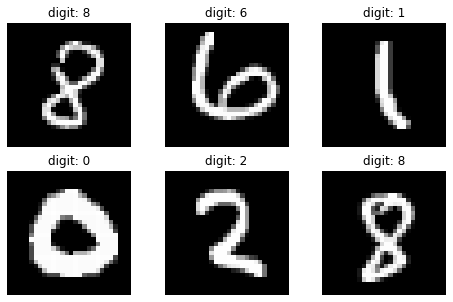

In [122]:
fig = plt.figure(figsize=(8 ,5))
samples, labels = next(iter(train_loader))
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(samples[i][0, :, :].data.cpu().numpy(), cmap='gray')
    title = "digit: " + str(labels[i].data.cpu().item())
    ax.set_title(title)
    ax.set_axis_off()

let's implement some standart training loop

In [123]:
# create our model
vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)

# optimizer 
vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)

# save the losses from each epoch, we might want to plot it later
train_losses = []

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    batch_losses = []
    for batch_i, batch in enumerate(train_loader):
        # forward pass
        x = batch[0].to(device).view(-1, X_DIM)  # just the images
        x_recon, mu, logvar, z = vae(x)
        # calculate the loss
        loss = loss_function(x_recon, x, mu, logvar, loss_type='bce')
        # optimization (same 3 steps everytime)
        vae_optim.zero_grad()
        loss.backward()
        vae_optim.step()
        # save loss
        batch_losses.append(loss.data.cpu().item())
    train_losses.append(np.mean(batch_losses))
    print("epoch: {} training loss: {:.5f} epoch time: {:.3f} sec".format(epoch, train_losses[-1],
                                                                          time.time() - epoch_start_time))
    
    
"""
# save
fname = "./vae_mnist_" + str(NUM_EPOCHS) + "_epochs.pth"
torch.save(vae.state_dict(), fname)
print("saved checkpoint @", fname)

# load
vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
vae.load_state_dict(torch.load(fname))
print("loaded checkpoint from", fname)
"""

epoch: 0 training loss: 172.04647 epoch time: 8.102 sec
epoch: 1 training loss: 129.49287 epoch time: 6.353 sec
epoch: 2 training loss: 123.41245 epoch time: 6.278 sec
epoch: 3 training loss: 120.18398 epoch time: 6.360 sec
epoch: 4 training loss: 118.11179 epoch time: 6.336 sec
epoch: 5 training loss: 116.66331 epoch time: 6.248 sec
epoch: 6 training loss: 115.57425 epoch time: 6.322 sec
epoch: 7 training loss: 114.71304 epoch time: 6.260 sec
epoch: 8 training loss: 114.01384 epoch time: 6.269 sec
epoch: 9 training loss: 113.46672 epoch time: 6.305 sec
epoch: 10 training loss: 112.93190 epoch time: 6.287 sec
epoch: 11 training loss: 112.53787 epoch time: 6.312 sec
epoch: 12 training loss: 112.11449 epoch time: 6.281 sec
epoch: 13 training loss: 111.75082 epoch time: 6.252 sec
epoch: 14 training loss: 111.42505 epoch time: 6.322 sec


'\n# save\nfname = "./vae_mnist_" + str(NUM_EPOCHS) + "_epochs.pth"\ntorch.save(vae.state_dict(), fname)\nprint("saved checkpoint @", fname)\n\n# load\nvae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)\nvae.load_state_dict(torch.load(fname))\nprint("loaded checkpoint from", fname)\n'

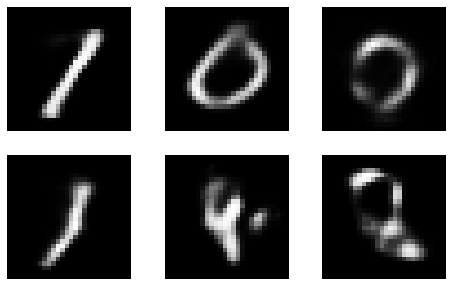

In [124]:
# now let's sample from the vae
n_samples = 6
vae_samples = vae.sample(num_samples=n_samples).view(n_samples, 28, 28).data.cpu().numpy()
fig = plt.figure(figsize=(8 ,5))
for i in range(vae_samples.shape[0]):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(vae_samples[i], cmap='gray')
    ax.set_axis_off()

#### Investigate $z$ with interpulation

we can create:
$$ z_{new} = \alpha z_1 + (1-\alpha) z_2, \alpha \in [0,1] $$ 

and see the transition between the 2 images.

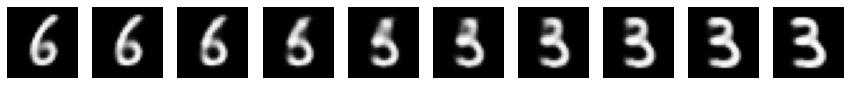

In [125]:
alphas = np.linspace(0.1, 1, 10)
# take 2 samples
sample_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, drop_last=True)
it = iter(sample_dataloader)
samples, labels = next(it)
while labels[0] == labels[1]:
    # make sure they are different digits
    samples, labels = next(it)
x_1, x_2 = samples

# get their latent representation
_,_, _, z_1 = vae(x_1.view(-1, X_DIM).to(device))
_,_, _, z_2 = vae(x_2.view(-1, X_DIM).to(device))

# let's see the result
fig = plt.figure(figsize=(15 ,8))
for i, alpha in enumerate(alphas):
    z_new = alpha * z_1 + (1 - alpha) * z_2
    x_new = vae.decode(z_new)
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(x_new.view(28, 28).cpu().data.numpy(), cmap='gray')
    ax.set_axis_off()

Let's see what we've learned with T-SNE, to reduce dimention and cluster the outputs :)

Text(0.5, 1.0, 't-SNE of VAE Latent Space on MNIST')

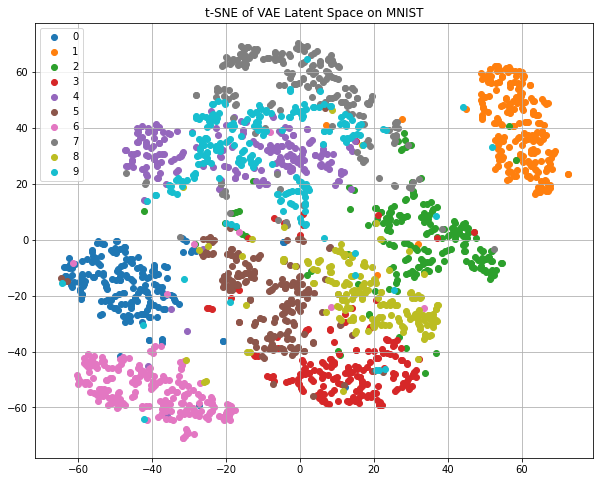

In [126]:
# take 2000 samples
num_samples = 2000
sample_dataloader = DataLoader(train_dataset, batch_size=num_samples, shuffle=True, drop_last=True)
samples, labels = next(iter(sample_dataloader))

labels = labels.data.cpu().numpy()
# decode the samples
_,_, _, z = vae(samples.view(num_samples, X_DIM).to(device))

# t-SNE
perplexity = 15.0
t_sne = TSNE(n_components=2, perplexity=perplexity)
z_embedded = t_sne.fit_transform(z.data.cpu().numpy())

# plot
fig = plt.figure(figsize=(10 ,8))
ax = fig.add_subplot(1, 1, 1)
for i in np.unique(labels):
    ax.scatter(z_embedded[labels==i,0], z_embedded[labels==i, 1], label=str(i))
ax.legend()
ax.grid()
ax.set_title("t-SNE of VAE Latent Space on MNIST")

## GAN (Generative Adverserial Networks)

This brulient idea came to life in <a href="http://papers.nips.cc/paper/5423-generative-adversarial-nets">Generative Adversarial Networks</a>, NIPS 2014, by Ian Goodfellow.

Gan is an implicit model, means it does not try to estimate $P(X)$ explicitly like VAE (not even $P(X|z$).

GAN has two components, `Generator` and `Discriminator` and the goal is to reach **zero-sum** cooperative game between them (minimax), as one component is adversery to the other.


`Generator` - generate fake samples.<br>
`Discriminator` - Try to detect fake samples and real samples.<br>

while both components could work by themself, they train in an adversery setup, means that they harm each other convergence.

before we dive into details, think that you pre-train a good Discriminator. now we want to train a Generator, but every attempt to generate good data is detected and it can't learn...

the same idea, let's say we somehow created an Okay Generator, if the discriminator can't distingish between fake and real, it can't give a feedback to improve the generator anymore.

<center><img src="resources/2cf8b4f1-7163-4af1-aa4b-6066329d554a.png" width="750"/></center>

from game theory, the GAN model **converges** when the `discriminator` and the `generator` reach a **Nash equilibrium**.

<center><img src="resources/russel.jpg" width="750"/></center>
image from "A Beautiful Mind"
<br>
<br>
<br>



**Nash equilibrium** - happens when all of the *players* will not change their *action* regardless of what the opponents may do.
in the word of neural nets- each component is a *player* and updating the weights is the *action* 

Note that this time, Cost functions may **not** converge using gradient descent optimization, due to minimax game (this is not the same as converging to a bad local minima).

At each time step we train both (in turns), and the goal is to reach equlibirum of both parts

<center><img src="resources/gan_architecture-1.png" width="750"/></center>

let's look at an example:
<center><img src="resources/1_hmbyMq-akpx-VRq7ZfnGFA.png" width="750"/></center>




### GAN Loss
---

Denote Discriminator as $D$,  Generator by $G$ and reward function by $V$,

The GAN's objective (Loss) function: $$ \min_G \max_D V(D,G)$$

It is formulated as a **minimax game**:
- $D$ is trying to *maximize* its reward $V(D, G)$
- $G$ is trying to *minimize* the Discriminator's reward (or maximize its loss)


**minimizing the Discriminator's reward** means that the Discriminator can not tell the difference between real and fake samples, thus, the Generator is "winning".


**Note** that we can't use one loss function (or can we?), as we did with the VAE, since each part here try to optimize the opposite, so we need two steps:

when we train the `Discriminator`, we freeze the generator and backpropogate the discriminator
<center><img src="resources/gan_diagram_discriminator.svg" width="750"/></center>


when we train the `Generator`, we freeze the discriminator and backpropogate the Generator

<center><img src="resources/gan_diagram_generator.svg" width="750"/></center>


$$ V(D,G) = \mathbb{E}_{x \sim p(x)} \left[ \log D(x) \right] + \mathbb{E}_{z\sim q(z)} \left[\log(1 - D\left(G(z)\right)) \right] $$
    
where D output's binary classification `0` for fake and `1` for real, and we use Binary Cross Entropy loss


<center><img src="resources/1_losses.png" width="900"/></center>

For a given generator, the optimal discriminator is $D^*(x) = \frac{P_{data}(x)}{P_{data}(x) + P_{G}(x)} $

the proof comes from information theory, we actually using [Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) , do you remember **KL-divergence** (of course you do, we just learned it)?


$$ JSD( p_G\mid \mid p_{data}) = JSD(p_{data} \mid \mid p_G) = \frac{1}{2}KL\left(p_{data} \mid \mid \left(\frac{p_{data} + p_G}{2}\right)\right) +  \frac{1}{2}KL\left(p_G \mid \mid \left(\frac{p_{data} + p_G}{2}\right)\right)$$


* The **Nash equilibrium** is reached when:
    * $P_{data}(x) = P_{gen}(x), \forall x$
    * $D(x) = \frac{1}{2}$ (completely random classifier).
    
you can read the [Mathematical proof of Nash Equilibrium in GANs](https://srome.github.io/An-Annotated-Proof-of-Generative-Adversarial-Networks-with-Implementation-Notes/)


we're **not** going to go deeper into information theory or the proofs since that's out of the scope of the course.

for some intuition, you can try to see the process in [GANLab](https://poloclub.github.io/ganlab/)

In [163]:
random_seed = 0
generator_learning_rate = 0.0005
discriminator_learning_rate = 0.0005
NUM_EPOCHS = 100 #200
BATCH_SIZE = 128
Z_DIM = 100 
HIDDEN_SIZE = 128
X_DIM = 28 * 28  # size of the input dimension

In [164]:
class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            nn.Linear(Z_DIM, HIDDEN_SIZE),
            nn.LeakyReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(HIDDEN_SIZE, X_DIM),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(X_DIM, HIDDEN_SIZE),
            nn.LeakyReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(HIDDEN_SIZE, 1),
            #nn.Sigmoid() # WGAN should have linear activation
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [165]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [166]:
##for your pleasure later
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)

def Training_GAN(model,train_loader, optim_gener, optim_discr,model_name='GAN',epochs=10,**kwargs):
    start_time = time.time()

    discr_costs = []
    gener_costs = []
    for epoch in range(epochs):
        model = model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):



            features = (features - 0.5)*2.
            features = features.view(-1, X_DIM).to(device) 
            targets = targets.to(device)

            # Regular GAN:
            if model_name=='GAN':
                valid = torch.ones(targets.size(0)).float().to(device)
                fake = torch.zeros(targets.size(0)).float().to(device)

            # WGAN:
            else:
                valid = -(torch.ones(targets.size(0)).float()).to(device)
                fake = torch.ones(targets.size(0)).float().to(device)


            ### FORWARD AND BACK PROP


            # --------------------------
            # Train Generator
            # --------------------------

            # Make new images
            z = torch.zeros((targets.size(0), Z_DIM)).uniform_(-1.0, 1.0).to(device)
            generated_features = model.generator_forward(z)

            # Loss for fooling the discriminator
            discr_pred = model.discriminator_forward(generated_features)


            # Regular GAN:
            if  model_name=='GAN':
                gener_loss = F.binary_cross_entropy_with_logits(discr_pred, valid)

            # WGAN:
            else:
                gener_loss = wasserstein_loss(valid, discr_pred)

            optim_gener.zero_grad()
            gener_loss.backward()
            optim_gener.step()

            # --------------------------
            # Train Discriminator
            # --------------------------        


            # WGAN: 5 loops for discriminator
            for _ in range(1):

                discr_pred_real = model.discriminator_forward(features.view(-1, X_DIM))
                # Regular GAN:
                if  model_name=='GAN':
                    real_loss = F.binary_cross_entropy_with_logits(discr_pred_real, valid)
                # WGAN:
                else:
                    real_loss = wasserstein_loss(valid, discr_pred_real)

                discr_pred_fake = model.discriminator_forward(generated_features.detach())

                # Regular GAN:
                if  model_name=='GAN':
                    fake_loss = F.binary_cross_entropy_with_logits(discr_pred_fake, fake)
                # WGAN:
                else:
                    fake_loss = wasserstein_loss(fake, discr_pred_fake)

                # Regular GAN:
                if  model_name=='GAN':

                    discr_loss = (real_loss + fake_loss)
                # WGAN:
                else:
                    discr_loss = -(real_loss - fake_loss)

                optim_discr.zero_grad()
                discr_loss.backward()
                optim_discr.step()        

                # WGAN:
                if not model_name =='GAN':
                    weight_clip_value = 0.01
                    for p in model.discriminator.parameters():
                        p.data.clamp_(-weight_clip_value, weight_clip_value)

            discr_costs.append(discr_loss.item())
            gener_costs.append(gener_loss.item())

            ### LOGGING
            if not batch_idx % 100:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), gener_loss, discr_loss))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return discr_costs,gener_costs

In [ ]:
discr_costs,gener_costs = Training_GAN(model=model,train_loader=train_loader, optim_gener=optim_gener, optim_discr=optim_discr,model_name='GAN',epochs=NUM_EPOCHS)

<ipython-input-161-91d95871d0fb>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(newlabel[::10])


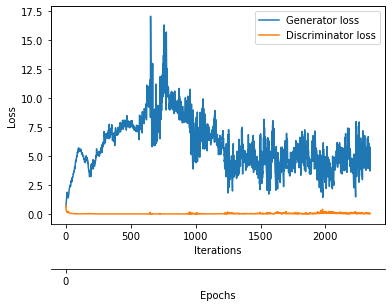

In [161]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

###################
# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())
###################

plt.show()

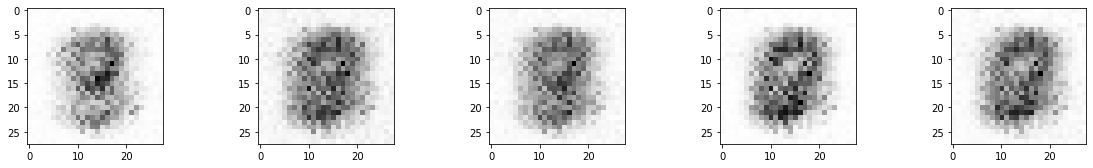

In [162]:
model.eval()
# Make new images
z = torch.zeros((5, Z_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')

### [this person does not exist](https://thispersondoesnotexist.com/)

## GANs problems
---

* **Loss oscilate**: oscilated loss is not stable, due to the adverserial set-up and (almost) never converge.
<center><img src="resources/gan_osil.png" width="500"/></center>


* **Mode Collapse**: the *Generator* collapses, which produces limited varieties of samples.
    - 2D eight-Gaussians dataset
<center><img src="resources/collaps.PNG" width="500"/></center>

[source](https://arxiv.org/pdf/1611.02163.pdf)
    
* **Vanisihng/Diminishing Gradient**: the discriminator gets *too good* such that the generator gradient vanishes and learns nothing.
    * Proof: consider the second term in the objective function which is relavent only for the generator.
        * Recall that the output of binary classification is the output of the *sigmoid* function, $\sigma$.
        * $\nabla_{\theta_G}V(D,G) = \nabla_{\theta_G}\mathbb{E}_{z\sim q(z)} \left[\log(1 - D\left(G(z)\right)) \right]$
        * $\nabla_a \log\left(1 - \sigma(a)\right) = \frac{-\nabla_a \sigma(a)}{1 - \sigma(a)} = \frac{-\sigma(a)\left(1 - \sigma(a)\right)}{1 - \sigma(a)} = -\sigma(a) = -D\left(G(z)\right)$
        * So if $D$ is confident (that the sample is fake), the gradient goes to 0, i.e. $D\left(G(z)\right) \to 0$
    * Possible remedy: replace the problematic term with $$ \mathbb{E}_{z\sim q(z)} \left[\log(1 - D\left(G(z)\right)) \right] \rightarrow -\mathbb{E}_{z\sim q(z)} \left[\log D\left(G(z)\right) \right] $$
    
* **GANs are highly sensitive to hyper-parameters!**
    * Even the slightest change in hyper-parameters may lead to any of the above, e.g. even changing the learning rate from 0.0002 to 0.0001 may lead to instability. 
    

## Deep Conv GAN (DCGAN)
---

As we've already learned with DNNs, the next idea after MLP, at least with images is always convolutions.

The idea is as follow:
- Replace fully-connected (FC) hidden layers with convolutions.
- Use fractional stride/transpose convolutions (in G)
- Use *Batch Normalization* after each layer.
- Hidden layers are activated with ReLUs.
- Output layer is activated with Tanh (normalized between $[-1, 1]$).

<center><img src="resources/DCGAN.png" width="1200"/></center>


## The Next step
---

* **WGAN** - [Wasserstein GANs](https://arxiv.org/abs/1701.07875) use the Wasserstein ([Earth Movers](https://en.wikipedia.org/wiki/Earth_mover%27s_distance)) distance as the loss function.<br> Think of it as so far, we measure the Jensen-Shannon divergence, a “vertical“ distance of distribution. this GAN make use of a "horizontal" distance to ensure higher rate of convergence. That makes the training more stable.

<center><img src="resources/wdistance.PNG" width="1200"/></center>

* **WGAN-GP** - improves upon the original WGAN by using *Gradient Penalty* in the loss function (instead of *value clipping*)
    
* **EBGAN** - [Energy-Based GANs](https://arxiv.org/abs/1609.03126) use *autoencoders* in their architecture (with the autoencoder loss).<br>
Yann LeCun (NYU, VP@META) is the current lead of energy based models in the world, we might talk about it in the last tutorial. 
    
* **BEGAN** - Boundary Equilibrium GANs combines *autoencoders* and Wassertein distance to balance the generator and discriminator during training.
    * <a href="https://arxiv.org/abs/1703.10717">BEGAN Paper</a>, <a href="https://github.com/anantzoid/BEGAN-pytorch">PyTorch Code</a>
* **Mimicry** - a lightweight PyTorch library aimed towards the reproducibility of GAN research - <a href="https://github.com/kwotsin/mimicry">GitHub</a>

## Conditional GAN
---

* As you probably have noticed, we don't too much control over the latent space, e.g., with vanilla-GAN trained on MNIST we can't control what digit we are generating.
* **Conditional-GANs** - a simple modification to the original GAN framework that *conditions* the model on additional information for better multi-modal learning.

<center><img src="resources/cgan.png" width="800"/></center>


1. **Conditional GAN**<br>
Conditional GAN (CGAN), the auxiliary data (class label) – is fed directly into both G and D. This has two benefits.
- It allows the user to control the feature being generated.
- A higher quality of generated sample can be achieved, since the distribution that the model learns to replicate is much more consistent when it represents the same digit.  The output of the Discriminator is still a probability, but now it is $P(X|c)$

2. **SGAN**<br>
Semi-Supervised GAN (SGAN), rather than feeding class labels into D, it is instead trained to assign class labels for itself.
- The output of D is no longer a probability, but a `softmax`, describing the output class. If the assigned class is between 0-9.
- Alternatively, the 11th potential class output is fake.
- This results with G which produces more convincing samples than in the original GAN model. This is intuitive, since D has an extra distinguishing factor than usual – it is arguably simpler to justify that ‘this image is probably real, since it looks like an eight’, than ‘this image is probably real’.

3. **InfoGAN**<br>
Information Theoretic GAN (InfoGAN), is another approach to conditional GANs. In this method, the specific distributions of the important features of latent codes, c, are not known. Instead, a prior is put on c and then updated, using observations, to come up with the conditional distribution $p(c|X)$.The form of the initial distribution of c allows some control over the modes which are distributed over.
- Think of it like that: instead of a discreat label added to the noise vector $Z$, we add a latent vector $C$ that represent better features of the sample (like shape, orientation)
- To ensure that the latent code is not ignored an extra term is added to the objective – the mutual information between c and the generated distribution, $G(z,c)$. D outputs both the probability that the sample is real or fake, plus the learned parameters, c. As well as providing a much more complex feature representation, this model allows us to fine tune many different aspects of the generated samples
<center><img src="resources/infogan.png" width="400"/></center>



4. **AC-GAN**<br>
Also by Odena (where the image is taken from) with Auxiliary-Classifier GAN (AC-GAN).

- Similarly to SGAN, D is trained to assign class labels to samples, however it is combined this time with the feature of CGANs, whereby the latent code, c, is also fed into G. That is, not only does G receive the noise sample, but a one-hot vector describing to which class the output should belong. restricting the number of classes that G is tasked to imitate results in better sample quality. This makes sense, as it is asked to learn fewer distributions. They also show how this model scales well to high-res distributions (for 2016), such as ImageNet.

## Latent space aritmetics
---

* As we learn how to transform a latent vector, $z$, to images, we actullay learn a latent continuous space.
* This continuous spcae allows us to perform interpolation and arithmetics.
* As this space is continuous, unlike the original data (images), it was found that some operations (like summing) perform really well when done on the latent space.
* As you can see below, those operations were demonstrated in the paper <a href="https://arxiv.org/abs/1511.06434">Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, Alec Radford, Luke Metz, Soumith Chintala, ICLR 2016</a>

<center><img src="resources/larit.PNG" width="700"/></center>
(from Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.)

one aplicable example could be hair style transfer (the rest you know from your phone aplications..)
<center><img src="resources/hairstyle.jpeg" width="800"/></center>



you can use [artbreeder](https://www.artbreeder.com/) to play with that some

### [Image-to-Image Translation with Conditional Adversarial Nets](https://phillipi.github.io/pix2pix/)
Pix2pix uses a conditional generative adversarial network (cGAN) to learn a function to map from an input image to an output image.
The Generator transforms the input image to get the output image.
The Discriminator measures the similarity of the input image to an unknown image (either a target image from the dataset or an output image from the generator) and tries to guess if it real or fake
some explenation [here](https://neurohive.io/en/popular-networks/pix2pix-image-to-image-translation/)

## New Kid on the block
---

As you can see, Researchers had trouble generating high-quality large images (e.g. 1024×1024) until 2018, when **NVIDIA** came up with Progressive Growing of GANs for Improved Quality, Stability, and Variation (**PROGAN**)

The key idea is to downsample images and train first (both G and D) by very small images, and increase size with time.<br>

<center><img src="resources/progan.PNG" width="800"/></center>

as it turns out, not only that small images train faster, but the features of small images are good for big images. and the hole optimization process is faster and achive better results. 

<center><img src="resources/progang.gif" width="800"/></center>

this model still lake of control over specific features of the generated image.
The features are entangled and therefore attempting to tweak the input, even a bit, usually affects multiple features at the same time...

In 2018 came a paper called **Style GAN** that took a step forward:

Nvidia distinguished between features that the generator can learn to produce in diffrent levels, and catalog them into 3:

- Coarse - resolution of up to 82 - affects pose, general hair style, face shape, etc
- Middle - resolution of 162 to 322 - affects finer facial features, hair style, eyes open/closed, etc.
- Fine - resolution of 642 to 10242 - affects color scheme (eye, hair and skin) and micro features.

## Links
---
### VAE
- <a href="https://www.youtube.com/watch?v=2pEkWk-LHmU">Machine Learning: Variational Inference</a>
- <a href="https://www.youtube.com/watch?v=uKxtmkfeuxg">Variational Inference Part 2 (KL divergence)</a>

### GAN
[Advanced Topics in GANs](https://towardsdatascience.com/comprehensive-introduction-to-turing-learning-and-gans-part-2-fd8e4a70775)

[GANs Awsome aplications](https://github.com/nashory/gans-awesome-applications)

[Pytorch zoo for GANs](https://github.com/znxlwm/pytorch-generative-model-collections)

[Gans traning tips](https://github.com/soumith/ganhacks)

### both

<a href="https://www.youtube.com/watch?v=5WoItGTWV54">Standord CS231n - Lecture 13 | Generative Models</a>


[RNN vs LSTM vs GRU](https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573)<br>
[LSTM and Bidirectional LSTM for Regression](https://towardsdatascience.com/lstm-and-bidirectional-lstm-for-regression-4fddf910c655)<br>
https://nlp.stanford.edu/pubs/glove.pdf glove


## Credits
---

This tutorial was written by [Moshe Kimhi](https://www.linkedin.com/in/moshekimhi/)<br>
GAN code based on [Sebastian Raschka rep](https://github.com/rasbt/deeplearning-models)<br>
To re-use, please provide attribution and link to the original.

images sources:

https://developers.google.com/machine-learning/gan/generator<br>
https://towardsdatascience.com/comprehensive-introduction-to-turing-learning-and-gans-part-2-fd8e4a70775